Import libary

In [1]:
import os
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import layers,Sequential,datasets,layers,optimizers,Sequential,metrics
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model

**1.ResNet20 & Data Prepossessing**

In [3]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
#train_x = train_x.astype("float32") / 255
#test_x = test_x.astype("float32") / 255
train_x, test_x = train_x / 255.0, test_x / 255.0
print(type(train_x))
print(type(test_x))

170508288/170498071 [==============================] - 2s 0us/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
train_x = train_x[:10000]
train_y = train_y[:10000]
print(train_x.shape)
print(train_y.shape)

(10000, 32, 32, 3)
(10000, 1)


In [5]:
##  Convert to one-hot encoding
def change_one_hot_label(X):
    Y = np.zeros((X.size, 10))
    for idx, row in enumerate(Y):
        row[X[idx]] = 1.0

    return Y

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


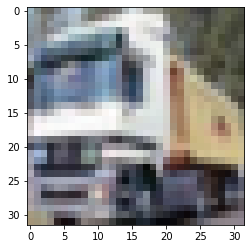

In [6]:
num_classes = 10
train_Y = change_one_hot_label(train_y)
test_Y = change_one_hot_label(test_y)
plt.imshow(train_x[1])
print(train_Y[1])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


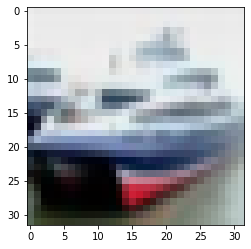

In [7]:
plt.imshow(test_x[1])
print(test_Y[1])

In [8]:
# z-normalize data
# normalize train set
train_x_std = np.std(train_x)
train_X = np.nan_to_num((train_x - np.mean(train_x,axis=0))/train_x_std) 
print(np.mean(train_X))
print(np.std(train_X))

# normalize test set
test_x_std = np.std(test_x)
test_X = np.nan_to_num((test_x - np.mean(test_x,axis=0))/test_x_std) 

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

7.071572956836766e-15
0.9888182087962077
(10000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)
(10000, 10)


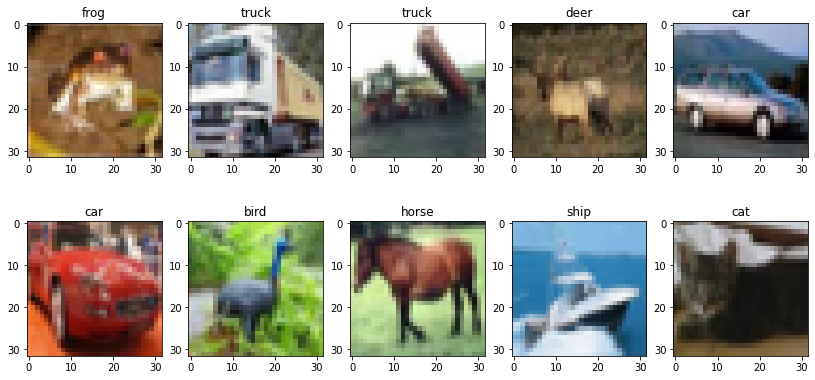

In [9]:
labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(14,14)) 
for i in range(10):   
    plt.subplot(4,5,i+1)
    plt.grid(False)
    plt.imshow(train_x[i])
    t = labels[train_y[i][0]]
    plt.title(t) 
plt.show()

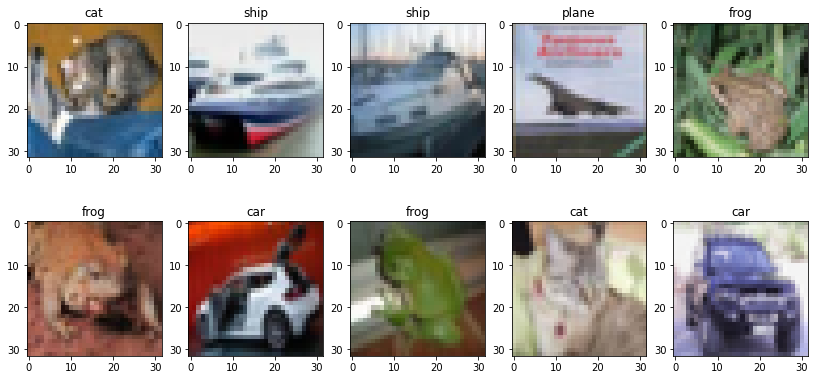

In [10]:
plt.figure(figsize=(14,14)) 
for i in range(10):   
    plt.subplot(4,5,i+1)
    plt.grid(False)
    plt.imshow(test_x[i])
    t = labels[test_y[i][0]]
    plt.title(t) 
plt.show()

In [11]:
from keras.models import Model, load_model
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

In [12]:
def ResNet20():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(16, 3, padding="same",
                      kernel_regularizer=l2(0.0001), kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    num_filters = 16
    for stack in range(3):
        for res_block in range(3):
            if stack > 0 and res_block == 0:
                shortcut = layers.Conv2D(num_filters, 1, strides=2, padding="same",
                                         kernel_regularizer=l2(0.0001), kernel_initializer='he_normal')(x)
                x = layers.Conv2D(num_filters, 3, strides=2, padding="same",
                                  kernel_regularizer=l2(0.0001), kernel_initializer='he_normal')(x)
            else:
                shortcut = x
                x = layers.Conv2D(num_filters, 3, padding="same",
                                  kernel_regularizer=l2(0.0001), kernel_initializer='he_normal')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation("relu")(x)
            x = layers.Conv2D(num_filters, 3, padding="same",
                              kernel_regularizer=l2(0.0001), kernel_initializer='he_normal')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Add()([shortcut, x])
            x = layers.Activation("relu")(x)
        num_filters *= 2
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(10, kernel_initializer='he_normal', activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
model = ResNet20()
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
model.summary()

2022-05-24 04:24:03.323677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 04:24:03.485016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 04:24:03.485869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 04:24:03.487511: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
checkpoint = ModelCheckpoint(filepath="models/ResNet20.h5", monitor='val_acc',
                             verbose=1, save_best_only=True)

In [15]:
History = model.fit(train_X, train_Y, batch_size=64,
                    validation_data=(test_X, test_Y),
                    epochs=100, verbose=1, callbacks=[checkpoint])

2022-05-24 04:24:07.382485: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-05-24 04:24:11.175471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 14s 30ms/step - loss: 1.9524 - acc: 0.3570 - val_loss: 2.2409 - val_acc: 0.2970

Epoch 00001: val_acc improved from -inf to 0.29700, saving model to models/ResNet20.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
157/157 [==============================] - 4s 26ms/step - loss: 1.5537 - acc: 0.4824 - val_loss: 2.1665 - val_acc: 0.3305

Epoch 00002: val_acc improved from 0.29700 to 0.33050, saving model to models/ResNet20.h5
Epoch 3/100
157/157 [==============================] - 4s 24ms/step - loss: 1.3670 - acc: 0.5583 - val_loss: 2.0615 - val_acc: 0.4026

Epoch 00003: val_acc improved from 0.33050 to 0.40260, saving model to models/ResNet20.h5
Epoch 4/100
157/157 [==============================] - 4s 24ms/step - loss: 1.2254 - acc: 0.6117 - val_loss: 1.4450 - val_acc: 0.5505

Epoch 00004: val_acc improved from 0.40260 to 0.55050, saving model to models/ResNet20.h5
Epoch 5/100
157/157 [==============================] - 4s 26ms/step - loss: 1.0837 - acc: 0.6686 - val_loss: 1.5094 - val_acc: 0.5257

Epoch 00005: val_acc did not improve from 0.55050
Epoch 6/100
157/157 [==============================] - 4s 26ms/step - loss: 0.9585 - acc: 0.7160 - val_loss: 1.8863 - val_acc: 0.4856

Epoch

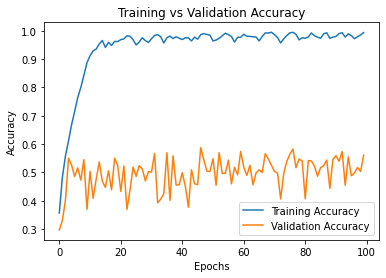

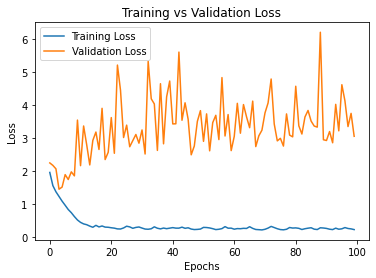

In [16]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
print(np.max(History.history["val_acc"]))

0.5877000093460083


2. Mixup

In [18]:
import numpy as np
print(np.random.beta(0.2,0.2))
print(np.random.beta(0.4,0.4))

0.12212603448857134
0.8789562309410871


In [19]:
print(train_x.shape[0])
a = np.random.choice(train_x.shape[0],size=1,replace=True)
print(a)
print([a[0]])

10000
[6899]
[6899]


In [20]:
def mixup(x1, y1, alpha,x2,y2):
# x = lambda*x_i+(1-lambda)*x_j
    lam = np.random.beta(alpha, alpha) #lambda
    img = lam * x1 + (1. - lam) * x2
    lab = lam * y1 + (1. - lam) * y2
        
    
    return img,lab

alpha = 0.2

[9.99987428e-01 1.25721841e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


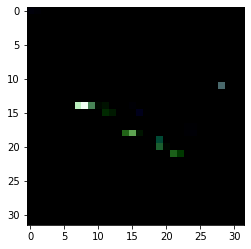

In [21]:
choice = np.empty(10000,int)
train_x_m1 = np.empty((10000, 32, 32, 3))
train_y_m1 = np.empty((10000, 10))
choice_x = np.empty((10000, 32, 32, 3))
choice_y = np.empty((10000, 10))


for i in range (10000):
    choice[i] =  np.random.choice(10000,size=1,replace=True)
    choice_x[i] = train_X[choice[i]] 
    choice_y[i] = train_Y[choice[i]] 
    train_x_m1[i],train_y_m1[i] = mixup (train_X[i], train_Y[i], 0.2,choice_x[i],choice_y[i])
    
    
plt.imshow(train_x_m1[5])
print(train_y_m1[5])

In [22]:
model = ResNet20()
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [23]:
checkpoint = ModelCheckpoint(filepath="models/ResNet20_m1.h5", monitor='val_acc',
                             verbose=1, save_best_only=True)

In [24]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False)
datagen.fit(train_x_m1)

In [25]:
History = model.fit_generator(datagen.flow(train_x_m1, train_y_m1, batch_size=64),
                    validation_data=(test_X, test_Y),
                    epochs=100, verbose=1, callbacks=[checkpoint])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
157/157 [==============================] - 12s 57ms/step - loss: 2.0528 - acc: 0.3387 - val_loss: 2.1320 - val_acc: 0.2961

Epoch 00001: val_acc improved from -inf to 0.29610, saving model to models/ResNet20_m1.h5
Epoch 2/100
157/157 [==============================] - 9s 58ms/step - loss: 1.7883 - acc: 0.4425 - val_loss: 2.2751 - val_acc: 0.3223

Epoch 00002: val_acc improved from 0.29610 to 0.32230, saving model to models/ResNet20_m1.h5
Epoch 3/100
157/157 [==============================] - 8s 52ms/step - loss: 1.6737 - acc: 0.4998 - val_loss: 1.9038 - val_acc: 0.4371

Epoch 00003: val_acc improved from 0.32230 to 0.43710, saving model to models/ResNet20_m1.h5
Epoch 4/100
157/157 [==============================] - 10s 64ms/step - loss: 1.5846 - acc: 0.5358 - val_loss: 4.0183 - val_acc: 0.2289

Epoch 00004: val_acc did not improve from 0.43710
Epoch 5/100
157/157 [==============================] - 9s 57ms/step - loss: 1.5058 - acc: 0.5789 - val_loss: 1.7193 - val_acc: 0.470

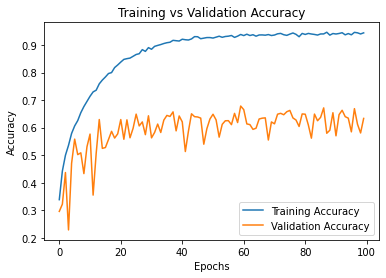

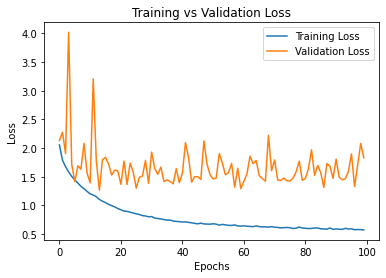

In [26]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
print(np.max(History.history["val_acc"]))

0.6783000230789185


alpha = 0.4

[0.         0.95168762 0.         0.         0.         0.
 0.         0.         0.         0.04831238]


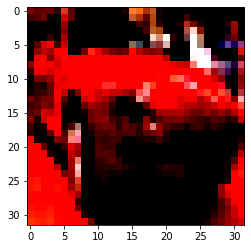

In [28]:
choice = np.empty(10000,int)
train_x_m2 = np.empty((10000, 32, 32, 3))
train_y_m2 = np.empty((10000, 10))
choice_x = np.empty((10000, 32, 32, 3))
choice_y = np.empty((10000, 10))


for i in range (10000):
    choice[i] =  np.random.choice(10000,size=1,replace=True)
    choice_x[i] = train_X[choice[i]] 
    choice_y[i] = train_Y[choice[i]] 
    train_x_m2[i],train_y_m2[i] = mixup (train_X[i], train_Y[i], 0.2,choice_x[i],choice_y[i])
    
    
plt.imshow(train_x_m2[5])
print(train_y_m2[5])

In [29]:
model = ResNet20()
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 32, 32, 16)   0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [30]:
checkpoint = ModelCheckpoint(filepath="models/ResNet20_m2.h5", monitor='val_acc',
                             verbose=1, save_best_only=True)

In [31]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False)
datagen.fit(train_x_m2)

In [32]:
History = model.fit_generator(datagen.flow(train_x_m2, train_y_m2, batch_size=64),
                    validation_data=(test_X, test_Y),
                    epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
157/157 [==============================] - 13s 62ms/step - loss: 2.4290 - acc: 0.2744 - val_loss: 2.1066 - val_acc: 0.3180

Epoch 00001: val_acc improved from -inf to 0.31800, saving model to models/ResNet20_m2.h5
Epoch 2/100
157/157 [==============================] - 9s 58ms/step - loss: 1.8909 - acc: 0.3919 - val_loss: 1.8474 - val_acc: 0.3962

Epoch 00002: val_acc improved from 0.31800 to 0.39620, saving model to models/ResNet20_m2.h5
Epoch 3/100
157/157 [==============================] - 8s 53ms/step - loss: 1.7672 - acc: 0.4475 - val_loss: 1.7912 - val_acc: 0.4072

Epoch 00003: val_acc improved from 0.39620 to 0.40720, saving model to models/ResNet20_m2.h5
Epoch 4/100
157/157 [==============================] - 9s 58ms/step - loss: 1.6708 - acc: 0.5022 - val_loss: 1.8135 - val_acc: 0.4163

Epoch 00004: val_acc improved from 0.40720 to 0.41630, saving model to models/ResNet20_m2.h5
Epoch 5/100
157/157 [==============================] - 8s 54ms/step - loss: 1.5968 - acc: 

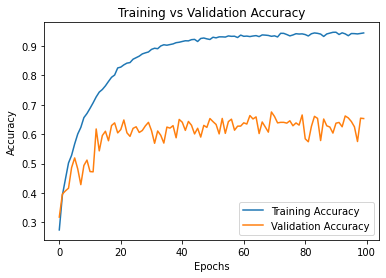

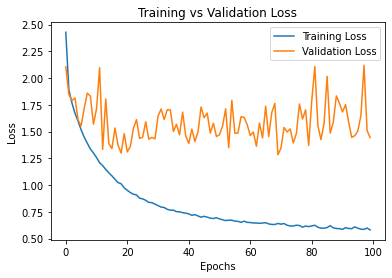

In [33]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
print(np.max(History.history["val_acc"]))

0.675599992275238


### 3.Cutout

In [35]:
A = np.random.randint(2, size=10)
print(A)

[0 0 1 0 0 1 1 1 0 1]


In [36]:
    def cutout(img,F):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.shape[1]
        w = img.shape[0]
     #print(h)
      # print(w)
        K  =16
        num_holes = 1
        mask = np.ones((h, w,3), np.float32)
       #print(mask.shape)
        
        for n in range(num_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - K // 2, 0, h)
            y2 = np.clip(y + K // 2, 0, h)
            x1 = np.clip(x - K // 2, 0, w)
            x2 = np.clip(x + K // 2, 0, w)

            mask[y1: y2, x1: x2, :] = 0.
       #print(mask.shape)
   
        img1 = img * mask
    
        if F == 1:
            return img1
        else:
            return img
        

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


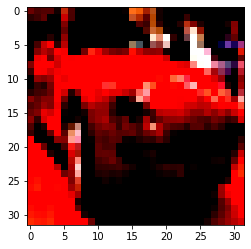

In [37]:
train_x_c = np.empty((10000, 32, 32, 3))
train_y_c = np.empty((10000, 10))
F = np.empty(10000)

for l in range (10000):
    F[l] =  np.random.randint(0, 2)
    train_x_c[l] = cutout(train_X[l],F[l])
    train_y_c[l] = train_Y[l]
    
plt.imshow(train_x_c[5])
print(train_y_c[5])

In [38]:
model = ResNet20()
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 16)   64          conv2d_63[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 32, 32, 16)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

In [39]:
checkpoint = ModelCheckpoint(filepath="models/ResNet20_c.h5", monitor='val_acc',
                             verbose=1, save_best_only=True)

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False)
datagen.fit(train_x_c)

In [40]:
History = model.fit_generator(datagen.flow(train_x_c, train_y_c, batch_size=64),
                    validation_data=(test_X, test_Y),
                    epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
157/157 [==============================] - 12s 59ms/step - loss: 2.0667 - acc: 0.3228 - val_loss: 2.4112 - val_acc: 0.2210

Epoch 00001: val_acc improved from -inf to 0.22100, saving model to models/ResNet20_c.h5
Epoch 2/100
157/157 [==============================] - 8s 54ms/step - loss: 1.7073 - acc: 0.4317 - val_loss: 3.3362 - val_acc: 0.2489

Epoch 00002: val_acc improved from 0.22100 to 0.24890, saving model to models/ResNet20_c.h5
Epoch 3/100
157/157 [==============================] - 9s 57ms/step - loss: 1.5809 - acc: 0.4805 - val_loss: 2.3799 - val_acc: 0.3934

Epoch 00003: val_acc improved from 0.24890 to 0.39340, saving model to models/ResNet20_c.h5
Epoch 4/100
157/157 [==============================] - 9s 56ms/step - loss: 1.4829 - acc: 0.5249 - val_loss: 1.4818 - val_acc: 0.5192

Epoch 00004: val_acc improved from 0.39340 to 0.51920, saving model to models/ResNet20_c.h5
Epoch 5/100
157/157 [==============================] - 8s 52ms/step - loss: 1.3996 - acc: 0.55

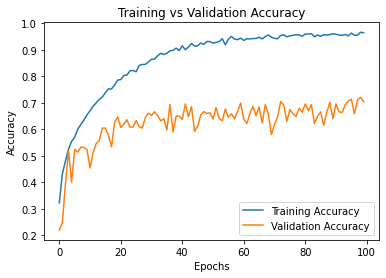

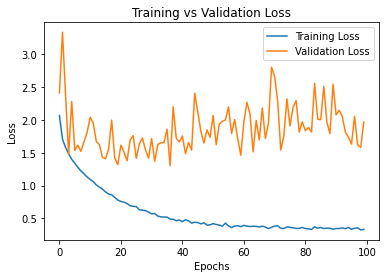

In [41]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
print(np.max(History.history["val_acc"]))

0.7202000021934509


4.Standard

In [43]:
import cv2

def horizontal_flip(img):

    flip_out = cv2.flip(img, 1)

    return flip_out


In [44]:
def random_shift(img,F):
    K = 4
    out = np.zeros((32, 32, 3))
    ##integers
    k1 = np.random.randint(-K, K)
    k2 = np.random.randint(-K, K)
    
    #upward(>0)
   
    if k1 > 0:
        for i in range(32-k1):
            for j in range(32):

                out[i][j][:] = img[i+k1][j][:]
    else:
    # downward(<0)
        for i in range(-k1,32):
            
            for j in range(32):
                out[i][j][:] = img[i+k1][j][:]
    
    # rightward
    if k2 > 0:
        for i in range(32):
            for j in range(32-k2):

                out[i][j][:] = img[i][j+k2][:]
    else:
    #leftward    
        for i in range(32):
            
            for j in range(-k2,32):
                out[i][j][:] = img[i][j+k2][:]
                
    if F == 1:
        flip_out = horizontal_flip(out)
        return flip_out
    else:
        return out

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


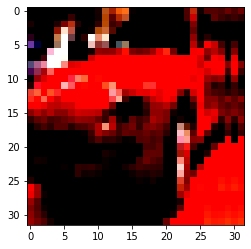

In [45]:
F = np.empty(10000)
train_x_s = np.empty((10000,32,32,3))
train_y_s = np.empty((10000,10))
for i in range(10000):
    F[i] =  np.random.randint(0, 2)
    train_x_s[i] = random_shift(train_X[i],F[i])
    train_y_s[i] = train_Y[i]
plt.imshow(train_x_s[5])
print(train_y_s[5])

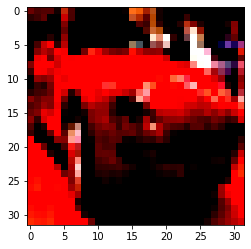

In [46]:
plt.imshow(train_X[5])

In [47]:
model = ResNet20()
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 32, 32, 16)   64          conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 32, 32, 16)   0           batch_normalization_76[0][0]     
____________________________________________________________________________________________

In [48]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False)
datagen.fit(train_x_s)

In [49]:
checkpoint = ModelCheckpoint(filepath="models/ResNet20_s.h5", monitor='val_acc',
                             verbose=1, save_best_only=True)

In [50]:
History = model.fit_generator(datagen.flow(train_x_s, train_y_s, batch_size=64),
                    validation_data=(test_X, test_Y),
                    epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
157/157 [==============================] - 12s 59ms/step - loss: 1.9607 - acc: 0.3373 - val_loss: 2.4988 - val_acc: 0.2612

Epoch 00001: val_acc improved from -inf to 0.26120, saving model to models/ResNet20_s.h5
Epoch 2/100
157/157 [==============================] - 8s 54ms/step - loss: 1.6657 - acc: 0.4418 - val_loss: 2.5691 - val_acc: 0.3436

Epoch 00002: val_acc improved from 0.26120 to 0.34360, saving model to models/ResNet20_s.h5
Epoch 3/100
157/157 [==============================] - 8s 54ms/step - loss: 1.5418 - acc: 0.4949 - val_loss: 1.8777 - val_acc: 0.3999

Epoch 00003: val_acc improved from 0.34360 to 0.39990, saving model to models/ResNet20_s.h5
Epoch 4/100
157/157 [==============================] - 9s 60ms/step - loss: 1.4414 - acc: 0.5354 - val_loss: 1.5852 - val_acc: 0.5067

Epoch 00004: val_acc improved from 0.39990 to 0.50670, saving model to models/ResNet20_s.h5
Epoch 5/100
157/157 [==============================] - 9s 55ms/step - loss: 1.3573 - acc: 0.56

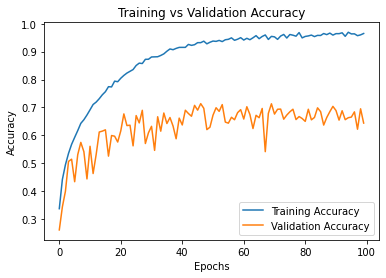

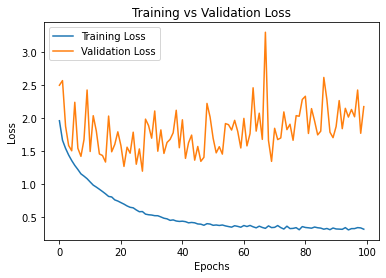

In [51]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
print(np.max(History.history["val_acc"]))
print(np.max(History.history["acc"]))

0.713699996471405
0.9695000052452087


5. combine

In [53]:
import cv2

In [54]:
 def combine(img,F,):

## mixup
        h = img.shape[1]
        w = img.shape[0]
     #print(h)
      # print(w)
        K = 16
        num_holes = 1
        mask = np.ones((h, w,3), np.float32)
       #print(mask.shape)
        
        for n in range(num_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - K // 2, 0, h)
            y2 = np.clip(y + K // 2, 0, h)
            x1 = np.clip(x - K // 2, 0, w)
            x2 = np.clip(x + K // 2, 0, w)

            mask[y1: y2, x1: x2, :] = 0.
       #print(mask.shape)
   
        img1 = img * mask
    
## cutout    

        L = 4
        out = np.zeros((32, 32, 3))
        ##integers
        k1 = np.random.randint(-L, L)
        k2 = np.random.randint(-L, L)

        #upward(>0)

        if k1 > 0:
            for i in range(32-k1):
                for j in range(32):

                    out[i][j][:] = img[i+k1][j][:]
        else:
        # downward(<0)
            for i in range(-k1,32):

                for j in range(32):
                    out[i][j][:] = img[i+k1][j][:]

        # rightward
        if k2 > 0:
            for i in range(32):
                for j in range(32-k2):

                    out[i][j][:] = img[i][j+k2][:]
        else:
        #leftward    
            for i in range(32):

                for j in range(-k2,32):
                    out[i][j][:] = img[i][j+k2][:]
                
        out = cv2.flip(out, 1)
    
        if F == 1:
            return img1
        else:
            return out

In [55]:
F = np.empty(10000)
train_x_com = np.empty((10000,32,32,3))
train_y_com = np.empty((10000,10))
for i in range(10000):
    F[i] =  np.random.randint(0, 2)
    train_x_com[i] = combine(train_X[i],F[i])
    train_y_com[i] = train_Y[i]

In [56]:
def mixup(x1, y1, alpha,x2,y2):
# x = lambda*x_i+(1-lambda)*x_j
    lam = np.random.beta(alpha, alpha) #lambda
    img = lam * x1 + (1. - lam) * x2
    lab = lam * y1 + (1. - lam) * y2
        
    return img,lab

[0.        0.0094216 0.        0.9905784 0.        0.        0.
 0.        0.        0.       ]


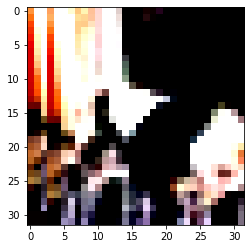

In [57]:
choice = np.empty(10000,int)
train_x_comb = np.empty((10000, 32, 32, 3))
train_y_comb = np.empty((10000, 10))
choice_x = np.empty((10000, 32, 32, 3))
choice_y = np.empty((10000, 10))


for i in range (10000):
    choice[i] =  np.random.choice(10000,size=1,replace=True)
    choice_x[i] = train_x_com[choice[i]] 
    choice_y[i] = train_y_com[choice[i]] 
    train_x_comb[i],train_y_comb[i] = mixup (train_x_com[i], train_y_com[i], 0.4, choice_x[i], choice_y[i])
    
    
plt.imshow(train_x_comb[5])
print(train_y_comb[5])

In [58]:
model = ResNet20()
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['acc'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 32, 32, 16)   64          conv2d_105[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 32, 32, 16)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [59]:
checkpoint = ModelCheckpoint(filepath="models/ResNet20_comb.h5", monitor='val_acc',
                             verbose=1, save_best_only=True)

In [60]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=False)
datagen.fit(train_x_comb)

In [61]:
History = model.fit_generator(datagen.flow(train_x_comb, train_y_comb, batch_size=64),
                    validation_data=(test_X, test_Y),
                    epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
157/157 [==============================] - 12s 53ms/step - loss: 2.1431 - acc: 0.3093 - val_loss: 1.9365 - val_acc: 0.3344

Epoch 00001: val_acc improved from -inf to 0.33440, saving model to models/ResNet20_comb.h5
Epoch 2/100
157/157 [==============================] - 8s 51ms/step - loss: 1.9432 - acc: 0.3963 - val_loss: 2.6354 - val_acc: 0.2473

Epoch 00002: val_acc did not improve from 0.33440
Epoch 3/100
157/157 [==============================] - 8s 51ms/step - loss: 1.8608 - acc: 0.4354 - val_loss: 1.9731 - val_acc: 0.4065

Epoch 00003: val_acc improved from 0.33440 to 0.40650, saving model to models/ResNet20_comb.h5
Epoch 4/100
157/157 [==============================] - 9s 55ms/step - loss: 1.7877 - acc: 0.4722 - val_loss: 2.3749 - val_acc: 0.3468

Epoch 00004: val_acc did not improve from 0.40650
Epoch 5/100
157/157 [==============================] - 9s 58ms/step - loss: 1.7360 - acc: 0.4968 - val_loss: 2.2413 - val_acc: 0.4024

Epoch 00005: val_acc did not improve 

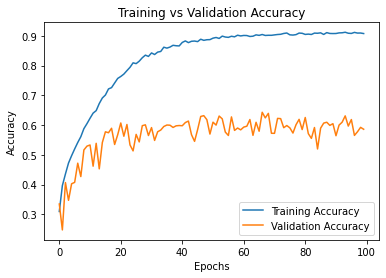

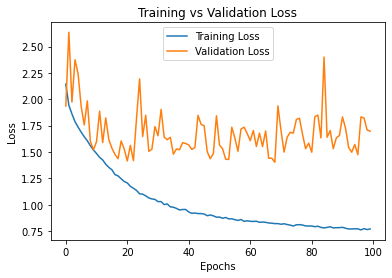

In [62]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [63]:
print(np.max(History.history["val_acc"]))
print(np.max(History.history["acc"]))

0.6428999900817871
0.9120000004768372


Q6. comment

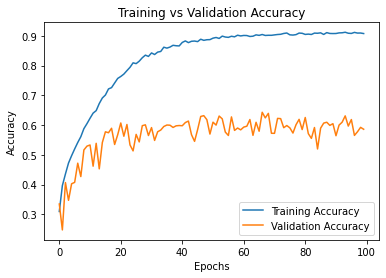

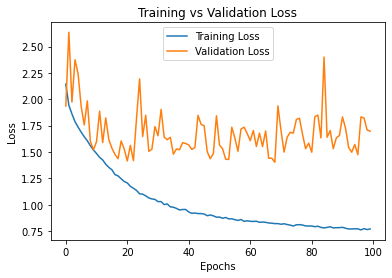

In [64]:
# Accuracy over training time
plt.plot(History.history['acc'], label="Training Accuracy")
plt.plot(History.history['val_acc'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss over training time
plt.plot(History.history['loss'], label="Training Loss")
plt.plot(History.history['val_loss'], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()